In [56]:
## The purpose of this notebook will be to use correlation matrices from each of the five sgRNA level maps to attempt
## to quantify differences in clustering fidelity, reasoning that high correlation in GI signature between sgRNAs
## targeting the same gene is a good metric for clustering quality control

## plots generated using this notebook are used in Figures 3B, 3D, S8A-F

In [3]:
## Import packages
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from sklearn import metrics
from scipy.stats import gaussian_kde

In [4]:
## Import data

## Import sgRNA level gimaps
dmso1_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso1_sgmap.xlsx',index_col=0)
atr_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/atr_sgmap.xlsx',index_col=0)
dmso2_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/dmso2_sgmap.xlsx',index_col=0)
etop_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/etop_sgmap.xlsx',index_col=0)
keto_sgmap = pd.read_excel('/Users/benh/Desktop/GI_data/guide_maps/keto_sgmap.xlsx',index_col=0)


## Import single sgRNA-Gene table
single_table = pd.read_excel('/Users/benh/Desktop/GI_data/singles_tables/singles_table.xlsx',index_col=0)

dmso1_sgmap = dmso1_sgmap.fillna(0)
atr_sgmap = atr_sgmap.fillna(0)
dmso2_sgmap = dmso2_sgmap.fillna(0)
etop_sgmap = etop_sgmap.fillna(0)
keto_sgmap = keto_sgmap.fillna(0)


In [5]:
## define the function "same_gene_corr" that takes a correlation matrix and returns the average correlation between
## pairs of sgRNAs that target the same gene

def same_gene_corr(corr_map):
    pair_list = []
    score_list = []
    for i in range(len(corr_map.index)):
        g1 = corr_map.index[i].split('_')[0]
        for j in range(i+1,len(corr_map.index)):
            g2 = corr_map.index[j].split('_')[0]
            if g1 == 'non-targeting':
                continue
            if g1 == g2:
                pair_list.append(g1)
                score_list.append(corr_map.iloc[i,j])
    return score_list


##Import Max's handy upperTriangle function to avoid counting AB BA GIs twice
def upperTriangle(matrix, k=1):
    keep = np.triu(np.ones(matrix.shape), k=k).astype('bool').reshape(matrix.size)
    return matrix.stack(future_stack = True).loc[keep]

In [6]:
## Find intersection between sgRNAs in all maps and slice all maps using this index

intersect = list(set(dmso2_sgmap.index).intersection(etop_sgmap.index).intersection(keto_sgmap.index).intersection(dmso1_sgmap.index).intersection(atr_sgmap.index))

dmso1_sgmap = dmso1_sgmap.loc[intersect,intersect]
atr_sgmap = atr_sgmap.loc[intersect,intersect]

dmso2_sgmap = dmso2_sgmap.loc[intersect,intersect]
etop_sgmap = etop_sgmap.loc[intersect,intersect]
keto_sgmap = keto_sgmap.loc[intersect,intersect]



In [7]:
## Make a consensus matrix by first normalizing each map by its standard deviation, then concatenating all five on the
## same axis, we will concat rows, as this plays nicer with the ".corr" tool in pandas

dmso2_sg_norm = dmso2_sgmap/dmso2_sgmap.values.std()
etop_sg_norm = etop_sgmap/etop_sgmap.values.std()
keto_sg_norm = keto_sgmap/keto_sgmap.values.std()

dmso1_sg_norm = dmso1_sgmap/dmso1_sgmap.values.std()
atr_sg_norm = atr_sgmap/atr_sgmap.values.std()

concat_sgmap = pd.concat((dmso2_sg_norm,etop_sg_norm,keto_sg_norm,dmso1_sg_norm,atr_sg_norm),axis=0)

In [8]:
## Make pearson correlation matrices for each map

dmso2_corr = dmso2_sgmap.corr('pearson')
etop_corr = etop_sgmap.corr('pearson')
keto_corr = keto_sgmap.corr('pearson')

dmso1_corr = dmso1_sgmap.corr('pearson')
atr_corr = atr_sgmap.corr('pearson')

concat_corr = concat_sgmap.corr('pearson')

In [9]:
## Calculate same-gene sgRNA correlation distributions for each map

dmso2_sg_corr = same_gene_corr(dmso2_corr)
etop_sg_corr = same_gene_corr(etop_corr)
keto_sg_corr = same_gene_corr(keto_corr)

dmso1_sg_corr = same_gene_corr(dmso1_corr)
atr_sg_corr = same_gene_corr(atr_corr)

concat_sg_corr = same_gene_corr(concat_corr)


In [10]:
print(np.mean(dmso2_sg_corr),np.mean(etop_sg_corr),np.mean(keto_sg_corr),np.mean(dmso1_sg_corr),np.mean(atr_sg_corr),np.mean(concat_sg_corr))


0.39706848151976754 0.43931849104957 0.3454124319343787 0.3935671983986563 0.5193743839790528 0.4303907858563662


In [28]:
print(np.mean(upperTriangle(atr_corr).values),np.mean(atr_sg_corr))

0.07102980452000023 0.5193743839790527


In [14]:
## populate a series of lists to be used in generating a matrix with guide pairs as the index and columns equivalent to the pair's 
## correlation in each of the GI maps, with a final column denoting if the pair of sgRNAs target the same gene

index_vector = []
dmso1_vector = []
atr_vector = []
dmso2_vector = []
etop_vector = []
keto_vector = []
consensus_vector = []
pair_vector = []

for i in range(len(dmso1_corr)):
    g1 = dmso1_corr.index[i].split('_')[0]
    for j in range(i+1,len(dmso1_corr)):
        g2 = dmso1_corr.index[j].split('_')[0]
        index_vector.append(dmso1_corr.index[i]+':'+dmso1_corr.index[j])
        dmso1_vector.append(dmso1_corr.iloc[i,j])
        atr_vector.append(atr_corr.iloc[i,j])
        dmso2_vector.append(dmso2_corr.iloc[i,j])
        etop_vector.append(etop_corr.iloc[i,j])
        keto_vector.append(keto_corr.iloc[i,j])
        consensus_vector.append(concat_corr.iloc[i,j])
        if g1 == g2:
            pair_vector.append('same')
        if g1 != g2:
            pair_vector.append('different')
        
        

In [15]:
## populate the full correlation matrix

corr_matrix = pd.DataFrame(index = index_vector)
corr_matrix['dmso1'] = dmso1_vector
corr_matrix['atr'] = atr_vector
corr_matrix['dmso2'] = dmso2_vector
corr_matrix['etop'] = etop_vector
corr_matrix['keto'] = keto_vector
corr_matrix['consensus'] = consensus_vector
corr_matrix['same_gene'] = pair_vector

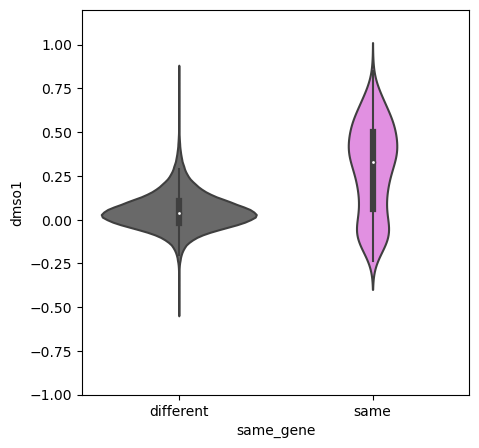

In [16]:
## generate a series of violin plots that compare correlation distributions for pairs of sgRNAs targeting different genes versus those pairs
## that target a single gene

## ref1

plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='dmso1',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/dmso1_sgrna_dis.png',dpi=300)

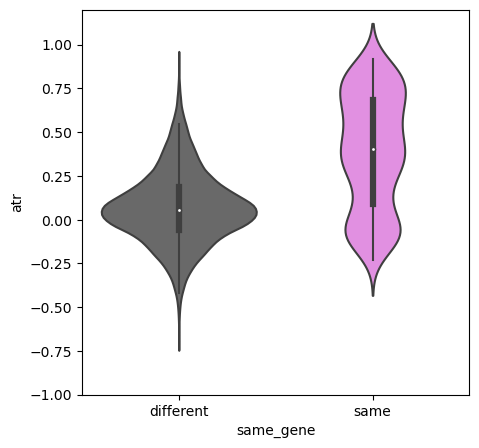

In [15]:
## atri

plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='atr',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)

/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/1255559358.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=corr_matrix,x='same_gene',y='dmso2',scale = 'area',palette=('dimgray','violet'))
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/1255559358.py:4: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(data=corr_matrix,x='same_gene',y='dmso2',scale = 'area',palette=('dimgray','violet'))


<Axes: xlabel='same_gene', ylabel='dmso2'>

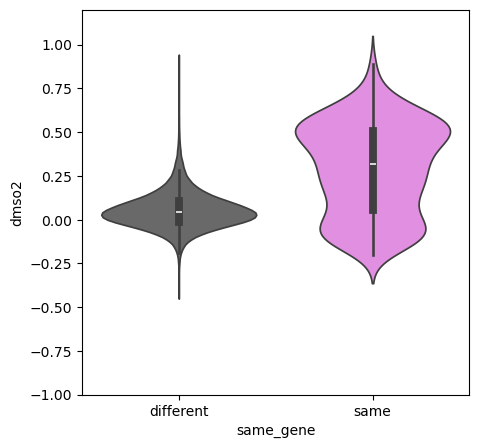

In [19]:
## ref2
plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='dmso2',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)

/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/1556028423.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=corr_matrix,x='same_gene',y='etop',scale = 'area',palette=('dimgray','violet'))
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/1556028423.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(data=corr_matrix,x='same_gene',y='etop',scale = 'area',palette=('dimgray','violet'))


<Axes: xlabel='same_gene', ylabel='etop'>

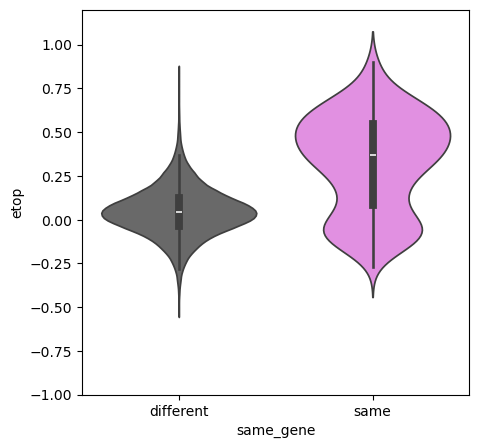

In [20]:
## etoposide

plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='etop',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)

/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/2555800719.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=corr_matrix,x='same_gene',y='keto',scale = 'area',palette=('dimgray','violet'))
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/2555800719.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(data=corr_matrix,x='same_gene',y='keto',scale = 'area',palette=('dimgray','violet'))


<Axes: xlabel='same_gene', ylabel='keto'>

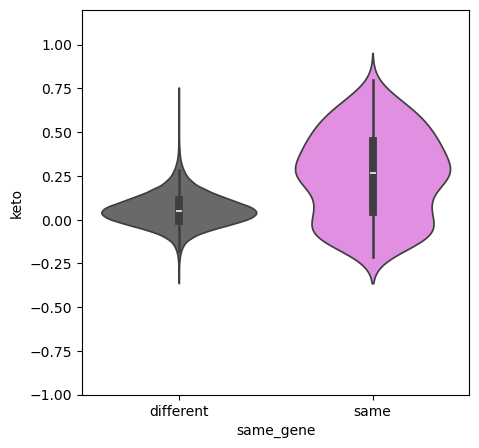

In [21]:
## glucose deprivation

plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='keto',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)

/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/2722114801.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=corr_matrix,x='same_gene',y='consensus',scale = 'area',palette=('dimgray','violet'))
/var/folders/wj/l9cwkbvn3f3b12_8zbvnd4500000gp/T/ipykernel_47256/2722114801.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='area'` for the same effect.
  sns.violinplot(data=corr_matrix,x='same_gene',y='consensus',scale = 'area',palette=('dimgray','violet'))


<Axes: xlabel='same_gene', ylabel='consensus'>

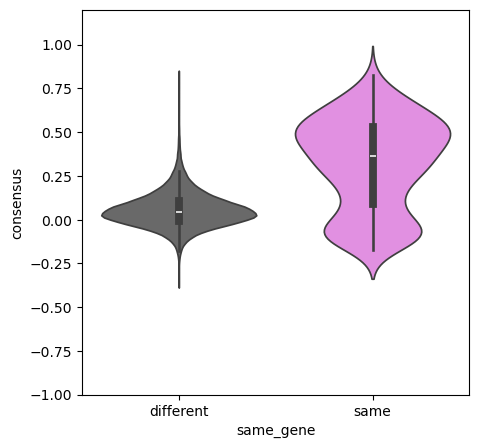

In [22]:
## consensus

plt.figure(figsize=(5,5))
plt.ylim(-1,1.2)
sns.violinplot(data=corr_matrix,x='same_gene',y='consensus',scale = 'area',palette=('dimgray','violet'))
#plt.savefig('/Users/benh/Desktop/for_figs/atr_sgrna_dis.png',dpi=300)